# [Advanced] Nano particle energy

本節は発展編の位置付けとします。次章へ急ぎたい方はスキップし、後から読んでいただいても構いません。

本節では、Nano particle (クラスター構造) の過剰エネルギー(excess energy)計算と、担体上の吸着構造作成を行ってみます。

In [1]:
import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode
from pfcc_extras.visualize.view import view_ngl


print(f"pfp_api_client: {pfp_api_client.__version__}")

# estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL, model_version="latest")
estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL_U0, model_version="v3.0.0")
calculator = ASECalculator(estimator)

pfp_api_client: 1.5.0


In [2]:
from ase.cluster import Decahedron, Icosahedron, Octahedron, wulff_construction
from ase import Atoms 
from ase.build import bulk
from ase.constraints import ExpCellFilter, StrainFilter
from ase.optimize import LBFGS
from ase.io import Trajectory
import numpy as np
import pandas as pd

## 過剰エネルギー - Excess energy

純金属に1種類以上他の元素を混ぜた材料を<b>合金 (alloy)</b>と呼びますが、
金属は2種類以上の元素を組み合わせることで、その性質を大きく変化させるようなものがあります。

例えば、アルミニウムと銅やマグネシウムを混ぜた、[ジュラルミン](https://ja.wikipedia.org/wiki/%E3%82%B8%E3%83%A5%E3%83%A9%E3%83%AB%E3%83%9F%E3%83%B3)はその軽くて硬い性質から航空宇宙機器などに使われています。

2種類の元素が混ざったものを2元系合金、3種類以上の元素が混ざったものは多元系合金と呼ばれます。

多元系合金は、新たな性質を持つような材料の発見も期待されていますが、
元素の種類が増えるほどその組成比の組み合わせが大きくなり、まだまだ解析が進んでいない領域です。<br/>
このような系も[Matlantis](https://matlantis.com)ではその汎用性を活かし、扱うことができます。


こういった合金の原子構造を考える際には、現実ではどのように混ざるのか、そもそもきれいに混ざることができる組み合わせなのかを知る必要があります。

このような合金の安定度合いを測る指標として、過剰エネルギー(excess energy)があります。<br/>
元素Aと元素Bを混ぜた2元系合金 (alloy)の過剰エネルギー(excess energy)は以下のように計算され、その合金のエネルギーが、元素A, Bがそれぞれ混ざっていなかった場合と比べてどのくらい安定かを示します。

$$ E_{\rm{excess}} = \frac{1}{N_{\rm{alloy}}} \left( E_{\rm{alloy}} - \frac{N_{\rm{alloyA}}}{N_{\rm{alloy}}} E_{\rm{A}} - \frac{N_{\rm{alloyB}}}{N_{\rm{alloy}}} E_{\rm{B}} \right) $$

$E_{\rm{alloy}}$が合金のエネルギー、$E_\rm{A}, E_\rm{B}$ は単原子AまたはBで構成された時のエネルギーで、$N_{\rm{alloy}}, N_{\rm{alloyA}}, N_{\rm{alloyB}}$はそれぞれ合金のすべての原子数、元素Aの原子数、元素Bの原子数です。

多元系の場合も同様に定義できます。

ここでは、PtとPdを混ぜた構造に対して、excess energyを評価することでその安定性を評価してみましょう。

参考文献:

 - [Electronic Structure and Phase Stability of PdPt Nanoparticles](https://pubs.acs.org/doi/10.1021/acs.jpclett.5b02753)
 - [Electronic structure and phase stability of Pt3M (M = Co, Ni, and Cu) bimetallic nanoparticles](https://www.sciencedirect.com/science/article/abs/pii/S0927025620303657)
 - [Calculations of Real-System Nanoparticles Using Universal Neural Network Potential PFP](https://arxiv.org/abs/2107.00963)

Pt711 Nano particleに対して、Pdを混ぜた構造に対して、
2元系のNano particleを考えた場合にもその混ざり方は様々な可能性が考えられます。

今回は以下のような構造を作成し、そのexcess energyを評価してみます。

 - PtとPdが均等に混ざる形で存在する構造
 - Ptが内殻に、Pdが外殻に存在する構造
 - Pdが内殻に、Ptが外殻に存在する構造

Core shell構造を作成する関数定義です。読み飛ばしていただいて構いません。

In [3]:
from typing import List, Tuple

from ase import Atoms, neighborlist
from ase.cluster import Cluster
import numpy as np
from ase.data import atomic_numbers


def cluster2atoms(cluster: Cluster) -> Atoms:
    """Convert ASE Cluster to ASE Atoms

    Args:
        cluster (Cluster): input cluster instance

    Returns:
        atoms (Atoms): converted output, atoms instance
    """
    return Atoms(cluster.symbols, cluster.positions, cell=cluster.cell)


def calc_coordination_numbers(atoms: Atoms) -> Tuple[List[int], List[np.ndarray]]:
    """Calculates coordination number

    Args:
        atoms: input atoms

    Returns:
        cns (list): coordination number for each atom
        bonds (list): bond destination indices for each atom
    """
    nl = neighborlist.NeighborList(
        neighborlist.natural_cutoffs(atoms), self_interaction=False, bothways=True
    )
    nl.update(atoms)
    bonds = []
    cns = []
    for i, _ in enumerate(atoms):
        indices, offsets = nl.get_neighbors(i)
        bonds.append(indices)
        cns.append(len(indices))
    return cns, bonds


def substitute(scaffold: Atoms, sites: np.ndarray, elements: List[str]) -> Atoms:
    """Substibute `elements` to `sites` indices of `scaffold` atoms

    Args:
        scaffold (Atoms): Original input atoms
        sites (np.ndarray): site indices to substitute `elements`
        elements (list): elements to be substituted

    Returns:
        substituted (Atoms): substituted ase atoms
    """
    substituted = scaffold.copy()
    for site, element in zip(sites, elements):
        substituted.numbers[site] = atomic_numbers[element]
    return substituted


def make_core_shell(scaffold: Atoms, element: str) -> Atoms:
    """Make core shell structure

    Input `scaffold` element is kept inside core shell,
    and outside surface is replaced by `element`.

    Note that it is not fully tested.
    It was not guaranteed to work on all the cases.

    Args:
        scaffold (Atoms): input cluster structure
        element (str): outside surface element to be replaced

    Returns:
        coreshell (Atoms): core shell structure
    """
    # CN : vertex < edge < surface < core
    cn = np.array(calc_coordination_numbers(scaffold)[0])
    cn_set = np.unique(cn)
    vertexes = None
    surfaces = None
    cores = None
    if len(cn_set) == 1:
        pass
    elif len(cn_set) == 2:
        cores = np.where(cn == cn_set[1])[0]
        surfaces = np.where(cn == cn_set[0])[0]
    elif len(cn_set) == 3 or len(cn_set) == 4:
        cores = np.where(cn == cn_set[-1])[0]
        surfaces = np.where(cn != cn_set[-1])[0]
        vertexes = np.where(cn == cn_set[0])[0]
    else:
        cores = np.where(cn == cn_set[-1])[0]
        surfaces = np.where(cn != cn_set[-1])[0]
        vertexes = np.where(np.isin(cn, cn_set[:-3]))[0]

    if surfaces is None:
        core_shell = scaffold.copy()
    else:
        core_shell = substitute(scaffold, surfaces, [element] * len(surfaces))
    return core_shell


まず今回ベースとなるNano particle 骨格構造(scaffold)を作成します。

In [4]:
Pt711 = cluster2atoms(Octahedron("Pt", 11, cutoff=4))
view_ngl(Pt711)

`make_core_shell` 関数を用いて、ベース骨格の内殻のみ "Pd" 元素に置き換えた構造 Pd306Pt405構造を作成します。

In [5]:
Pd306Pt405 = make_core_shell(Pt711, "Pd")
view_ngl(Pd306Pt405)

同様にして、外殻がPd, 内殻がPtとなる構造Pd405Pt306を作成します。

In [6]:
Pd711 = Octahedron("Pd", 11, cutoff=4)
Pd405Pt306 = make_core_shell(Pd711, "Pt")
view_ngl(Pd405Pt306)

In [7]:
symbols, counts = np.unique(Pd405Pt306.symbols, return_counts=True)
print(f"Pd405Pt306 structure contains {symbols} with counts {counts}", )

symbols, counts = np.unique(Pd306Pt405.symbols, return_counts=True)
print(f"Pd306Pt405 structure contains {symbols} with counts {counts}", )

Pd405Pt306 structure contains ['Pd' 'Pt'] with counts [405 306]
Pd306Pt405 structure contains ['Pd' 'Pt'] with counts [306 405]


ここで得られたそれぞれの構造を構造緩和し、エネルギーを求めます。

In [8]:
from ase.optimize import FIRE

def get_opt_energy(atoms, fmax=0.001):    
    opt = FIRE(atoms)
    opt.run(fmax=fmax)
    return atoms.get_total_energy()

In [9]:
print("Optimizing Pt711")
Pt711.calc = calculator
E_pt711 = get_opt_energy(Pt711)

print("Optimizing Pd306Pt405")
Pd306Pt405.calc = calculator
E_pd306pt405 = get_opt_energy(Pd306Pt405)

print("Optimizing Pd405Pt306")
Pd405Pt306.calc = calculator
E_pd405pt306 = get_opt_energy(Pd405Pt306)

print("Optimizing Pd711")
Pd711.calc = calculator
E_pd711 = get_opt_energy(Pd711)

Optimizing Pt711
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 06:54:54    -3603.041770*       1.1063
FIRE:    1 06:54:54    -3604.081779*       1.0498
FIRE:    2 06:54:54    -3605.848377*       0.9306
FIRE:    3 06:54:55    -3607.344865*       0.7998
FIRE:    4 06:54:55    -3608.622478*       0.6640
FIRE:    5 06:54:55    -3609.735569*       0.5327
FIRE:    6 06:54:55    -3610.728639*       0.4144
FIRE:    7 06:54:56    -3611.628229*       0.3549
FIRE:    8 06:54:56    -3612.447484*       0.3436
FIRE:    9 06:54:56    -3613.187570*       0.3175
FIRE:   10 06:54:56    -3613.846037*       0.2669
FIRE:   11 06:54:57    -3614.425194*       0.2127
FIRE:   12 06:54:57    -3614.931713*       0.2186
FIRE:   13 06:54:57    -3615.369616*       0.2122
FIRE:   14 06:54:57    -3615.738931*       0.1940
FIRE:   15 06:54:58    -3616.044471*       0.1671
FIRE:   16 06:54:58    -3616.293988*       0.1389
FIRE:   17 06:54:58    -3616.481608

それぞれのエネルギーが得られたので、ここからexcess energyを計算することができます。

In [10]:
E_exess_pd306pt405 = (E_pd306pt405 - 306 / 711 * E_pd711 - 405 / 711 * E_pt711) / 711
E_exess_pd405pt306 = (E_pd405pt306 - 405 / 711 * E_pd711 - 306 / 711 * E_pt711) / 711

print(f"Excess energy of Pd306Pt405 = {E_exess_pd306pt405 * 1000:.2f} meV")
print(f"Excess energy of Pd405Pt306 = {E_exess_pd405pt306 * 1000:.2f} meV")

Excess energy of Pd306Pt405 = -44.26 meV
Excess energy of Pd405Pt306 = 2.36 meV


Excess energyが負となっているPd306Pt405は単独でPd, Pt nanoparticleが存在するよりも混合したほうが安定であるということを示唆しています。<br/>
一方で正となっているPd405Pt306の構造はPd306Pt405と比べると不安定であることになります。

この結果から、**PdとPtの合金微粒子では、Pdが外殻に来るような構造が自然界では安定して存在しそう**だという考察ができます。

最後に、Pt306個、Pd405個がランダムに配置されたような構造のexcess energyを求めてみましょう。

In [11]:
Pd405Pt306_random = Pt711.copy()
# randomly choose 405 atoms to be replaced to Pd
pd_indices = np.random.choice(np.arange(711), 405, replace=False)
Pd405Pt306_random.numbers[pd_indices] = atomic_numbers["Pd"]

print(f"Replaced to Pd with indices {pd_indices}")
view_ngl(Pd405Pt306_random)

Replaced to Pd with indices [196 552  99 568 368 382 471 105 599 212 637 142 432 304 663  49 680 302
 493 104 232 102 487 433 273 420 314 185  61 435 132 576 561 374 350  85
 581 240  13 699 666 359 616 571 600 110 327 201   8 347 146  55 593 351
 391 157 658 244 463 236 288 691 166  90 118 528  72 686 562 591 437 135
 690   4 702 225 137 223 404 138  98 145 623 676 525 621  64 466 328 221
 330 626 281 529 208 269 548 647 150 527 377 313 672 206 507   5 203 256
 584 375 317 614 100 602 510 217 394 315 649 414 312 661  27 467 673 540
 704 425 358 551 239 385 250  28 205 122 373 264 413 565 267 286 343 456
 601 230 386 532 307 153 556 679 172  91 655 569 202 268 181  95 484 173
 707  19 514 509 277 537 638  11 311 390 700  33 458 405 555  29 511 168
 684 363 428 590 444 371 303  65 594 366 361 450 566 657 520 550 338 154
 246  18 334 464 336 275  20 633 176 160 620 697 558  80  83 195 335 325
 305   0 278 117 597 615 131 671 322 674 128 438 596 133 254 197 439  47
  23 140 191 296 403  7

In [12]:
print("Optimizing Pd405Pt306_random")
Pd405Pt306_random.calc = calculator
E_pd405pt306_random = get_opt_energy(Pd405Pt306_random)

Optimizing Pd405Pt306_random
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 06:55:57    -2951.634114*       0.7943
FIRE:    1 06:55:58    -2952.049965*       0.7585
FIRE:    2 06:55:58    -2952.770701*       0.6876
FIRE:    3 06:55:58    -2953.619475*       0.5777
FIRE:    4 06:55:58    -2954.359894*       0.4618
FIRE:    5 06:55:58    -2954.930649*       0.3488
FIRE:    6 06:55:59    -2955.380034*       0.3323
FIRE:    7 06:55:59    -2955.741782*       0.2891
FIRE:    8 06:55:59    -2956.033248*       0.2633
FIRE:    9 06:55:59    -2956.257166*       0.2117
FIRE:   10 06:56:00    -2956.416871*       0.2094
FIRE:   11 06:56:00    -2956.526379*       0.1835
FIRE:   12 06:56:00    -2956.604745*       0.1840
FIRE:   13 06:56:00    -2956.665961*       0.1816
FIRE:   14 06:56:01    -2956.716348*       0.1827
FIRE:   15 06:56:01    -2956.747297*       0.1770
FIRE:   16 06:56:01    -2956.800838*       0.1661
FIRE:   17 06:56:01    

In [13]:
view_ngl(Pd405Pt306_random)

In [14]:
E_exess_pd405pt306_random = (E_pd405pt306_random - 405 / 711 * E_pd711 - 306 / 711 * E_pt711) / 711

print(f"Excess energy of Pd306Pt405 random = {E_exess_pd405pt306_random * 1000:.2f} meV")

Excess energy of Pd306Pt405 random = -31.22 meV


この場合も負のexcess energyが得られ、この構造が安定になりうるという結果が得られました。

今回は完全にランダムな配置を行って構造を作成しましたが、実際は物質が混ざる場合には局所的にパターンを取ることでより安定な構造となる可能性もあります。
こういった分析を進める場合はモンテカルロ法を用いて配置パターンを最適化するということがよく行われますがここでは省略します。<br/>
（モンテカルロ法の説明及びその実例については将来後述されるかもしれません。）

このように、様々な構造を作成し、そのexcess energyを計算することで合金の安定構造がどのようになるかを解析する事ができます。

## 担体上への微粒子吸着構造作成

本チュートリアルでは、担体上に微粒子をおいたモデリングの簡単な計算事例を紹介するにとどめ、この構造の現実での妥当性検証までは行いません。

ここでは、担持貴金属担体としてSnO2を、Nano particleとしてはPt を用いて、担体上へPt Nano particleを乗せた構造を作成してみます。

 - [The effect of SnO2(110) supports on the geometrical and electronic properties of platinum nanoparticles](https://link.springer.com/article/10.1007/s42452-019-1478-0)
 - [Calculations of Real-System Nanoparticles Using Universal Neural Network Potential PFP](https://arxiv.org/abs/2107.00963)

In [15]:
# bulk, support material
from ase.io import read
SnO2 = read("../input/SnO2_mp-856_conventional_standard.cif")
view_ngl(SnO2, representations=["ball+stick"])

ここではSlab構造の作成(Bulkからの特定ミラー面の切り出し)にpymatgenの `SlabGenerator` を用いています。<br/>
これは`SlabGenerator` のinstance化をする際の初期化パラメータとして作りたいSlab構造のパラメータを指定し、<br/>
`get_slabs` 関数を呼ぶことで指定された初期化パラメータにマッチするSlab構造が列挙されて得られます。

 - [pymatgen document](https://pymatgen.org/pymatgen.core.surface.html#pymatgen.core.surface.SlabGenerator)

詳しくは、以下のMaterials Project Workshopでも紹介されています。

 - [Working with Surfaces and Interfaces - The Materials Project Workshop](https://workshop.materialsproject.org/lessons/03_heterointerfaces/Main%20Lesson/)

In [16]:
# Generate slab
from ase.build import make_supercell
import numpy as np
from pymatgen.core.surface import SlabGenerator
from pymatgen.io.ase import AseAtomsAdaptor


slab_gen = SlabGenerator(
    initial_structure=AseAtomsAdaptor.get_structure(SnO2),
    miller_index=[1,1,0],
    min_slab_size=5.0, # ここで層の出方が変わる
    min_vacuum_size=15.0, # nanoparticleを載せるので大きめに
    lll_reduce=False,
    center_slab=True,
    primitive=True,
    max_normal_search=1,
)
slabs = slab_gen.get_slabs(tol=0.3, bonds=None, max_broken_bonds=0, symmetrize=False)

得られた `slabs` はpymatgenのinstanceです。これは、`AseAtomsAdaptor` を用いてASEの`Atoms` instanceに変換することができます。

得られた構造をASE `Atoms`に変換して、可視化してみます。

In [17]:
slab_atoms_list = [AseAtomsAdaptor.get_atoms(slab) for slab in slabs]
view_ngl(slab_atoms_list, representations=["ball+stick"])

２つの構造が得られました。

以降では2つ目の構造を使用して、Slabを作成していきます。

ASEでsupercellを作成した後、z軸方向に平行移動して一番下にある原子(Layer)の高さが0になるよう設定しています。

In [18]:
slab = slab_atoms_list[1].copy()

# make supercell: expand to xy-plane
#slab = make_supercell(slab, [[4, 0, 0], [0, 2, 0], [0, 0, 1]])  # this is same with below.
slab = slab * (4, 2, 1)

# shift `slab` to bottom of cell
min_pos_z = np.min(slab.positions, axis=0)[2]
slab.set_positions(slab.positions - [0, 0, min_pos_z])

In [19]:
view_ngl(slab, representations=["ball+stick"], replace_structure=True)

担体のSlab構造を作成することができました。

次にこの担体上に乗せるNano particle clusterを作成します。

In [20]:
Pt55 = Octahedron("Pt", 5, cutoff=2)

# cut cluster to make half-sphere
cluster = Pt55.copy()
# Rotate cluster to make triangle surface comes to top.
cluster.rotate([0, 0, 1], [1, 1, 1], center=cluster.get_center_of_mass())
# Cut bottom 2 layers
for _ in range(2):
    target = np.round(cluster.positions, decimals=0)
    del cluster[np.where(target[:,2]==np.min(target[:,2]))[0]]

In [21]:
view_ngl(cluster, representations=["ball+stick"])

Nano particle clusterを担体の上に乗せましょう。

ここでは、プログラムを書いて担体真ん中の上にNano particleを乗せていますが、
5章で紹介する`SurfaceEditor`を用いると、InteractiveにNano particleを移動させて初期構造を作成することも可能です。

In [22]:
from ase.data import atomic_numbers, chemical_symbols, covalent_radii


# Put Pt37 on top of SnO2. Both perpendincular lines goes z-axis.
slab_xy_size = np.min(slab.cell.cellpar()[0:2])
cluster_xy_size = np.max(
    (np.max(cluster.positions, axis=0) - np.min(cluster.positions, axis=0))[0:2]
)
# Vacuum size
min_slab_xy_size = cluster_xy_size + 15
for i in range(1, 5):
    print(f"i={i}")
    if slab_xy_size * i < min_slab_xy_size:
        pass
    else:
        slab_sc = make_supercell(slab, [[i, 0, 0], [0, i, 0], [0, 0, 1]])
        break
slab_surface_xy_center = np.append(
    slab_sc.cell.cellpar()[0:2] / 2, np.max(slab_sc.positions, axis=0)[2]
)
cluster_surface_xy_center = np.append(
    np.mean(cluster.positions, axis=0)[0:2], np.min(cluster.positions, axis=0)[2]
)
cluster = Atoms(cluster.get_chemical_symbols(), cluster.positions - cluster_surface_xy_center)
slab_surface_covalent_radii = covalent_radii[
    slab_sc.get_atomic_numbers()[np.argmax(slab_sc.positions, axis=0)[2]]
]
cluster_surface_covalent_radii = covalent_radii[
    cluster.get_atomic_numbers()[np.argmin(cluster.positions, axis=0)[2]]
]
cluster.translate(
    slab_surface_xy_center + [0, 0, slab_surface_covalent_radii + cluster_surface_covalent_radii]
)
supported = slab_sc.copy()
supported += cluster

i=1
i=2


In [23]:
view_ngl(supported, representations=["ball+stick"])

In [24]:
import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode
from ase.optimize import BFGS, LBFGS, FIRE
from ase.io import Trajectory
print(f"pfp_api_client: {pfp_api_client.__version__}")

estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL, model_version="v3.0.0")
calculator = ASECalculator(estimator)
supported.calc = calculator
traj = Trajectory("./SnO2_Pt119.traj", "w", supported)
opt = FIRE(supported)
opt.attach(traj.write, interval=1)
opt.run(fmax=0.005)
traj.close()

pfp_api_client: 1.5.0
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 06:58:31    -1860.090772*       2.7723
FIRE:    1 06:58:31    -1866.458047*       2.3451
FIRE:    2 06:58:31    -1871.904323*       2.0879
FIRE:    3 06:58:31    -1876.434307*       2.0256
FIRE:    4 06:58:32    -1880.091439*       1.9501
FIRE:    5 06:58:32    -1882.952912*       1.8591
FIRE:    6 06:58:32    -1885.147381*       1.7505
FIRE:    7 06:58:32    -1886.867019*       1.6223
FIRE:    8 06:58:32    -1888.358989*       1.4732
FIRE:    9 06:58:33    -1889.852164*       1.4049
FIRE:   10 06:58:33    -1891.473457*       1.2978
FIRE:   11 06:58:33    -1893.201623*       1.0758
FIRE:   12 06:58:33    -1894.904770*       0.9423
FIRE:   13 06:58:33    -1896.433910*       0.9369
FIRE:   14 06:58:33    -1897.707551*       0.9101
FIRE:   15 06:58:34    -1898.742282*       0.8622
FIRE:   16 06:58:34    -1899.634513*       0.8619
FIRE:   17 06:58:34    -1900.4

In [25]:
SnO2_Pt119 = Trajectory("./SnO2_Pt119.traj")
view_ngl(SnO2_Pt119, representations=["ball+stick"])

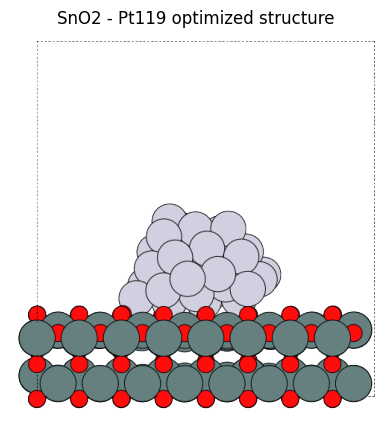

In [26]:
from ase.io import write
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


write("output/sno2_pt119_opt.png", SnO2_Pt119[-1], rotation="-90x,0y,0z")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(mpimg.imread("output/sno2_pt119_opt.png"))
ax.set_axis_off()
ax.set_title("SnO2 - Pt119 optimized structure")
fig.show()

このように、担体上のNano particle 構造を作成することができました。

ここで、論文で示されているようなchargeの可視化も可能です。<br/>
Nano particleの吸着面に近いところでのみ電荷が０からずれていて、核の外側がプラスに、内側がマイナスになっていることが確認できます。

In [27]:
v = view_ngl(SnO2_Pt119[-1], show_charge=True)
v.show_charge_label()
v

このように、SnO2担体上にPt Nano particleが吸着している構造を作成することができました。

実際には、本当にこの構造で正しいのか（微粒子の状態で吸着するのか、それとも全体に均質に伸びて吸着するような形のほうが安定なのかなど)の検証が必要となりますが、このTutorialでは省略します。

こういった構造が作成できる事により、ここから更に後述する反応探索やMDなどを組み合わせることで、

 - 様々な面が露出している触媒下での反応
 - 触媒と担体の境界面での反応

なども扱えるようになる可能性があり、より現実に近い状態での触媒反応シミュレーションができる可能性があります。

参考文献

 - [Calculations of Real-System Nanoparticles Using Universal Neural Network Potential PFP](https://arxiv.org/abs/2107.00963)
 - [Structural Stability of Ruthenium Nanoparticles: A Density Functional Theory Study](https://pubs.acs.org/doi/10.1021/acs.jpcc.7b08672)
 - [Electronic Structure and Phase Stability of PdPt Nanoparticles](https://pubs.acs.org/doi/10.1021/acs.jpclett.5b02753)
 - [Electronic structure and phase stability of Pt3M (M = Co, Ni, and Cu) bimetallic nanoparticles](https://www.sciencedirect.com/science/article/abs/pii/S0927025620303657)
 - [The effect of SnO2(110) supports on the geometrical and electronic properties of platinum nanoparticles](https://link.springer.com/article/10.1007/s42452-019-1478-0)